In [1]:
library(tidyverse)
library(yaml)
library(rstan)
library(tidybayes)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: StanHeaders


rstan version 2.32.3 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
chan

## Config and data

In [2]:
config_id <- "pooling_sim_full_pool"
data_config_id <- "pooling_sim"

In [3]:
data_config <- yaml.load_file(paste0("../data/configs/", data_config_id, "/data.yaml"))
main_config <- yaml.load_file(paste0("../experiments/configs/", config_id, "/main.yaml"))

In [4]:
results_base_dir <- paste0("../experiments/results/", config_id)
if (!dir.exists(results_base_dir)) {
    dir.create(results_base_dir, recursive = TRUE)
}

### Data

In [5]:
data_base_dir <- paste0("../", data_config$output_dir)
data_path <- paste0(data_base_dir, "/data.csv")
beta_0 <- data_config$beta_0
beta_1 <- data_config$beta_1
n_measurements <- data_config$n_measurements

In [6]:
data_df <- read_csv(data_path)
fit_data_df <- data_df %>%
    filter(measurement_id < n_measurements)
eval_data_df <- data_df %>%
    filter(measurement_id == n_measurements)

Rows: 1500 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (8): group_id, group_effect, x, indiv_effect, indiv_id, measurement_id, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Model

In [7]:
model_seed <- main_config$seed
n_samp <- main_config$n_samp
n_warmup_samp <- main_config$n_warmup_samp
n_chains <- main_config$n_chains
model_file_path <- paste0("../", main_config$model_file_path)

## Model fitting

In [8]:
stan_data <- list(
    N = fit_data_df %>% nrow(),
    y = fit_data_df %>% pull(y),
    x = fit_data_df %>% pull(x),
    beta_0_mu_prior = beta_0,
    beta_0_sigma_prior = 10.0,
    beta_1_mu_prior = 1.0,
    beta_1_sigma_prior = 3.0
)

In [9]:
if (!file.exists(paste0(results_base_dir, "/fit.rds"))) {
    fit <- stan(
        file = model_file_path,
        data = stan_data,
        chains = n_chains,
        iter = n_samp,
        warmup = n_warmup_samp,
        seed = model_seed,
        cores = n_chains,
        pars = c("beta_0", "beta_1"),
        include = TRUE
    )
    saveRDS(fit, paste0(results_base_dir, "/fit.rds"))
    
    tidy_draws_df <- fit %>% tidybayes::spread_draws(beta_0, beta_1)
    tidy_draws_df %>%
        write_csv(paste0(results_base_dir, "/draws.csv"))
} else {
    fit <- readRDS(paste0(results_base_dir, "/fit.rds"))
    tidy_draws_df <- read_csv(paste0(results_base_dir, "/draws.csv"))
}

Rows: 4000 Columns: 5
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (5): .chain, .iteration, .draw, beta_0, beta_1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
tidy_draws_long_df <- tidy_draws_df %>%
    pivot_longer(cols = !c(".chain", ".iteration", ".draw"), names_to = "param")

In [11]:
fit_summary <- summary(fit)

In [12]:
fit_summary_df <- fit_summary$summary %>%
    as_tibble(rownames="param") %>%
    filter(param %in% c("beta_0", "beta_1"))

In [13]:
fit_summary_df

param,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
beta_0,12.7211040,0.004925072,0.22086910,12.2986732,12.5692310,12.7218274,12.866651,13.170952,2011.151,1.000077
beta_1,0.9834931,0.001756588,0.09009756,0.8065099,0.9242462,0.9856455,1.044809,1.153741,2630.792,1.000228


In [14]:
set_theme_elements <- function(plt) {
    plt +
        theme_classic() +
        theme(text = element_text(size=16))
}

# Settings for plots
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 100)

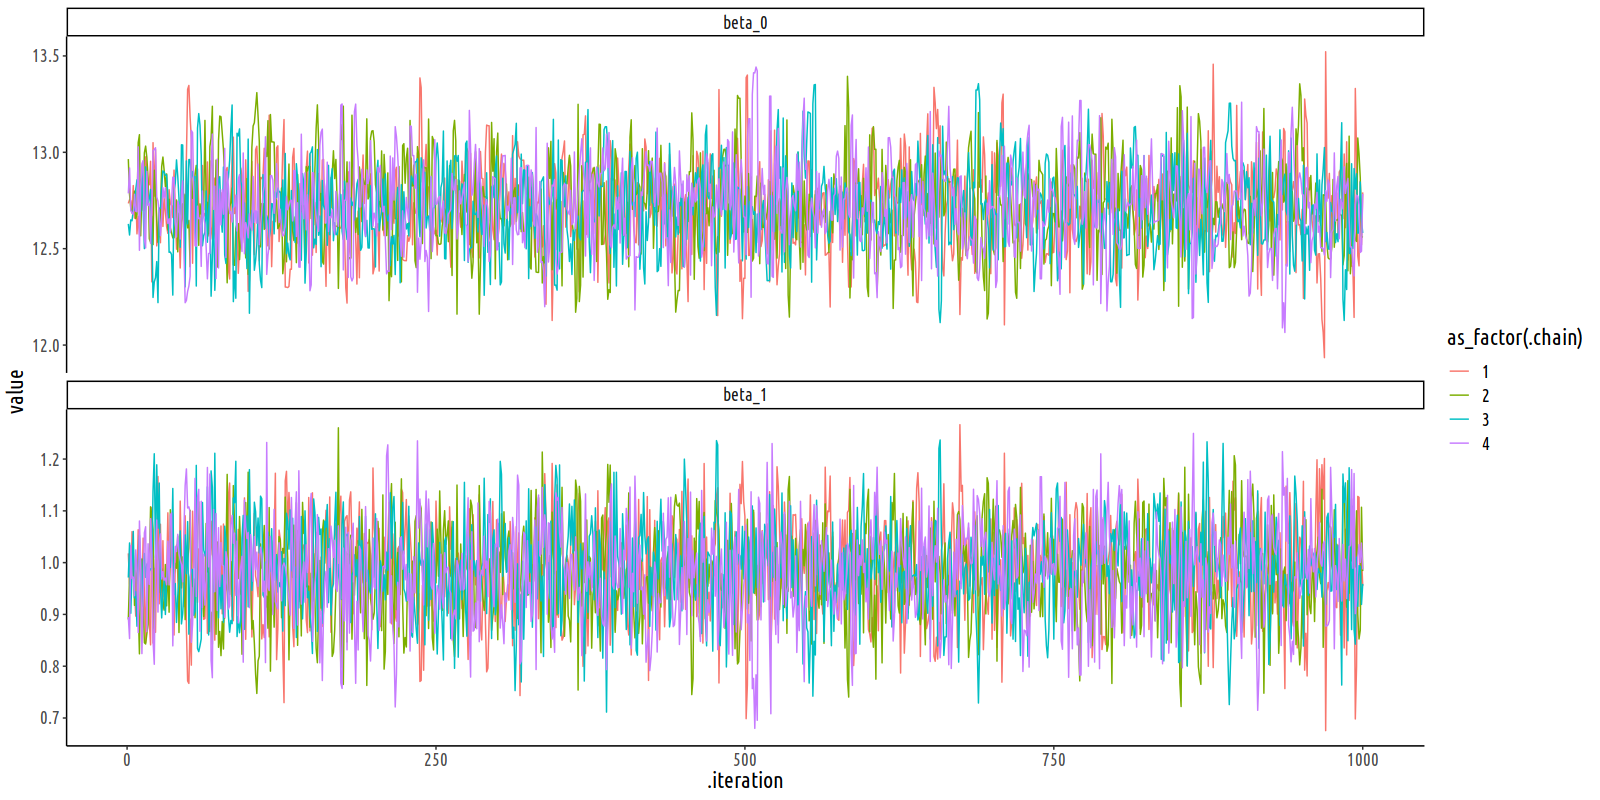

In [15]:
plt <- tidy_draws_long_df %>%
    ggplot(aes(x = .iteration, y = value, color = as_factor(.chain))) +
    geom_line() +
    facet_wrap(~ param, ncol=1, scales = "free_y")

plt <- plt %>%
    set_theme_elements()

plt

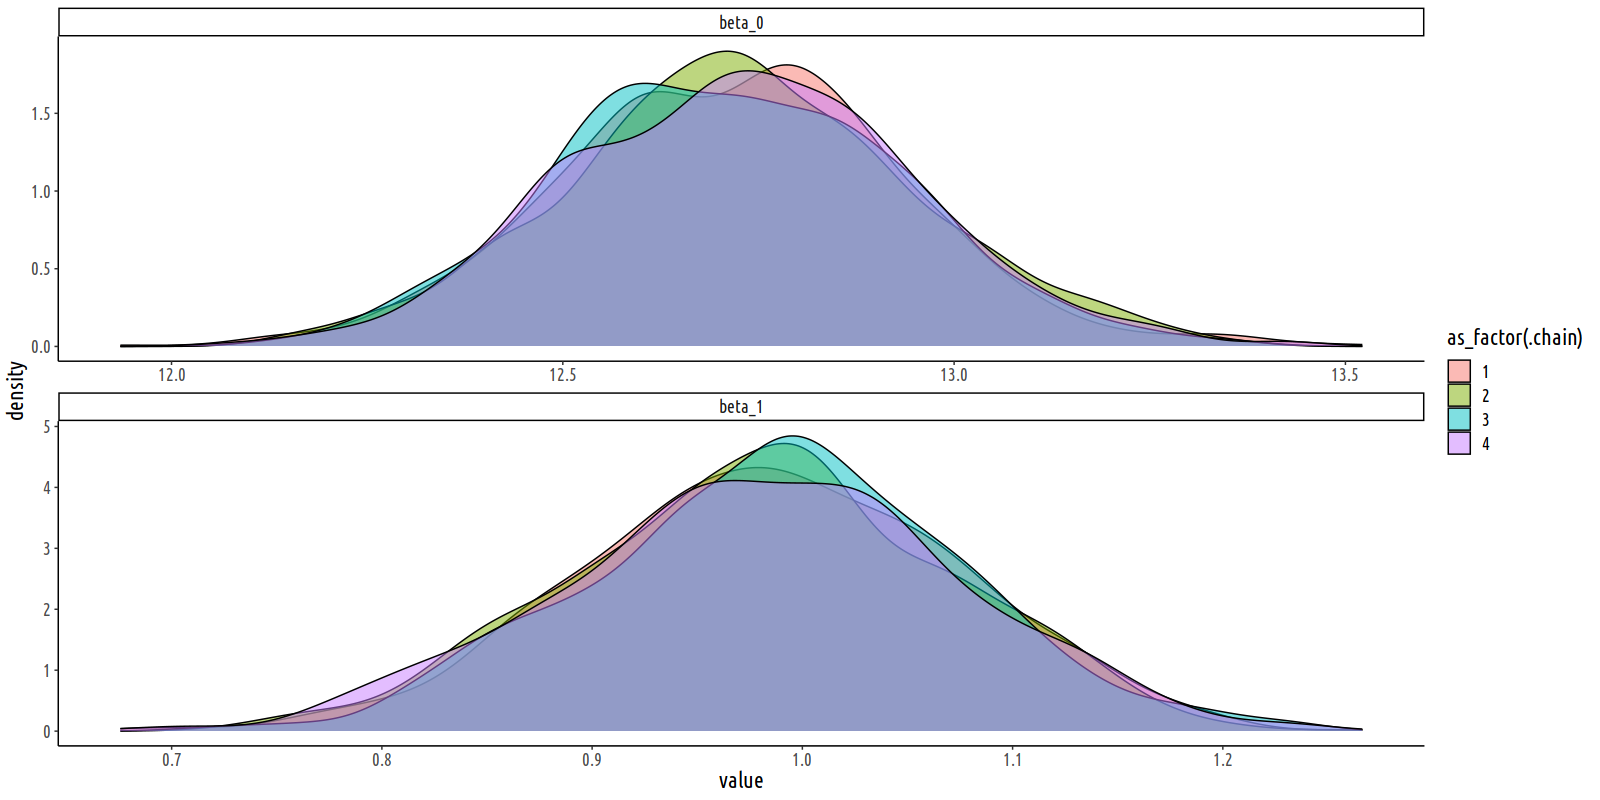

In [16]:
plt <- tidy_draws_long_df %>%
    ggplot(aes(x = value, fill = as_factor(.chain))) +
    geom_density(alpha = 0.5) +
    facet_wrap(~ param, scales = "free", ncol = 1)

plt <- plt %>%
    set_theme_elements()

plt

In [17]:
fit_summary_df

param,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
beta_0,12.7211040,0.004925072,0.22086910,12.2986732,12.5692310,12.7218274,12.866651,13.170952,2011.151,1.000077
beta_1,0.9834931,0.001756588,0.09009756,0.8065099,0.9242462,0.9856455,1.044809,1.153741,2630.792,1.000228


In [18]:
fit_params_df <- fit_summary_df %>%
    transmute(param, est_mean = mean, est_025 = `2.5%`, est_975 = `97.5%`) %>%
    mutate(param = str_replace(param, "beta_0", "beta_0_"))

In [19]:
fit_params_df

param,est_mean,est_025,est_975
<chr>,<dbl>,<dbl>,<dbl>
beta_0_,12.7211040,12.2986732,13.170952
beta_1,0.9834931,0.8065099,1.153741


In [35]:
est_vs_true_df <- data_df %>%
    distinct(
        indiv_id,
        group_id,
        group_effect,
        indiv_effect,
    ) %>%
    transmute(
        indiv_id,
        group_id,
        beta_1,
        beta_0_ = beta_0 + group_effect + indiv_effect
    ) %>%
    pivot_longer(!c(indiv_id, group_id), names_to = "param", values_to = "true") %>%
    inner_join(fit_params_df, by = "param")
    # group_by(param) %>%
    # summarize(rmse = sqrt(mean((true-est)^2)))

In [37]:
est_vs_true_df %>%
    head()

indiv_id,group_id,param,true,est_mean,est_025,est_975
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,beta_1,1.00000,0.9834931,0.8065099,1.153741
1,1,beta_0_,18.15966,12.7211040,12.2986732,13.170952
2,1,beta_1,1.00000,0.9834931,0.8065099,1.153741
2,1,beta_0_,19.14144,12.7211040,12.2986732,13.170952
3,1,beta_1,1.00000,0.9834931,0.8065099,1.153741
3,1,beta_0_,15.46593,12.7211040,12.2986732,13.170952


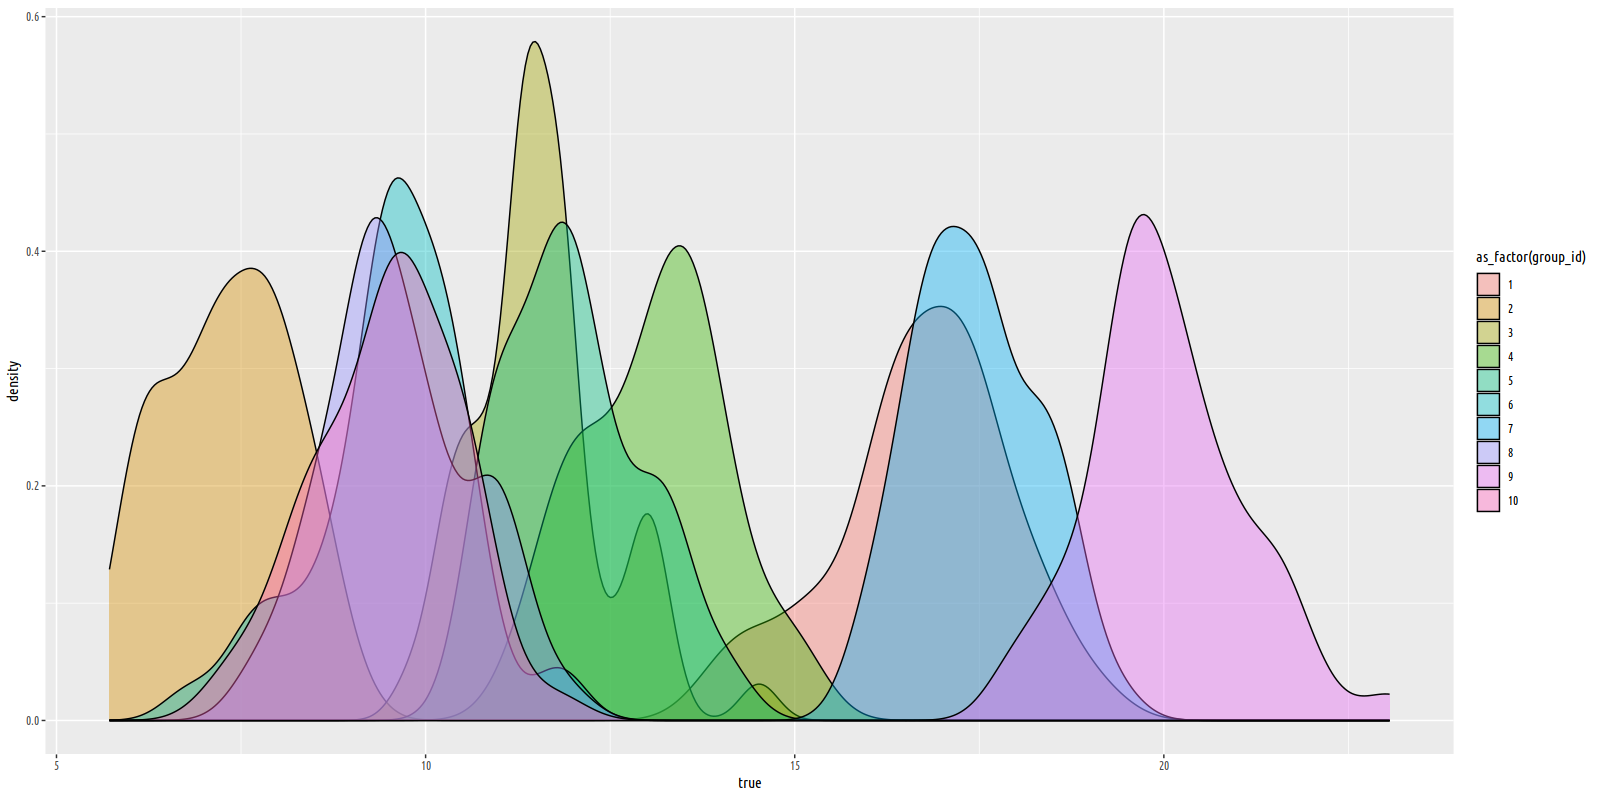

In [56]:
est_vs_true_df %>%
    filter(param == "beta_0_") %>%
    ggplot() +
    geom_density(aes(x = true, fill = as_factor(group_id), group = as_factor(group_id)), alpha = 0.4)
    # geom_vline(xintercept = )

In [21]:
# Recovery RMSE
est_vs_true_df %>%
    group_by(param) %>%
    summarize(rmse = sqrt(mean((true-est_mean)^2)))

param,rmse
<chr>,<dbl>
beta_0_,4.02568743
beta_1,0.01650692


In [22]:
# Recovery within 95% credibility interval
est_vs_true_df %>%
    mutate(within = as.integer(est_025 <= true & true <= est_975)) %>%
    group_by(param) %>%
    summarize(prop_in_95 = mean(within))

param,prop_in_95
<chr>,<dbl>
beta_0_,0.054
beta_1,1.000


In [23]:
post_predictions <- function(samp_df, x_df, n_post = 100) {
    betahat_0 <- sample(samp_df$beta_0, size = n_post, replace = TRUE)
    betahat_1 <- sample(samp_df$beta_1, size = n_post, replace = TRUE)
    # Pair samples of beta with each student (since fully pooled)
    pred_df <- tibble(betahat_0 = betahat_0, betahat_1 = betahat_1) %>%
        cross_join(x_df) %>%
        mutate(yhat = betahat_0 + betahat_1 * x)
    return(pred_df)
}

In [24]:
obs_df <- eval_data_df %>%
    select(
        indiv_id,
        x,
        y
    )

In [25]:
preds_df <- post_predictions(tidy_draws_df, obs_df, n_post = 100)

In [26]:
preds_df %>%
    mutate(
        se = (y - yhat)^2,
        resid = y - yhat
    ) %>%
    summarize(
        rmse = sqrt( mean(se) ),
        mean_resid = mean( abs(resid) )
    )

rmse,mean_resid
<dbl>,<dbl>
4.061236,3.409032
